## Momentum Trading Strategy Backtest

**Summary of project:**

### Libraries 

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs
import numpy as np


## Importing ETFs 

### **Moving Average Convergence Divergence**





**What is an EMA (Exponential Moving Average):**    

A moving average that puts more weight on recent prices so it reacts faster to new information than a simple moving average. 

For price $P_t$:    
$$
EMA_t = {\alpha}P_t+(1-\alpha)EMA_{t-1}
$$
where   
$$
\alpha =\frac{2}{N+1}
$$ 

and N is the lookback window, typically 12 days (fast EMA- half trading month) or 26 days (slow EMA- full trading month).


**Features**:
- The weight on prices decays so that observaions older than about N period contribute very little
- Each day back gets less importance than the day after it, so a 12 day or 26 day EMA still includes prices before that






**Advantages**

- EMA responds faster to recent price changes as today's weight has a big weight
- Simple moving average (SMA) would need days to notice

**MACD Line**    
- Measures momentum by asking if price rising daster now than it was recently by comparin a fast reaction to a slow reaction to price.
- The MACD line is defined by   

$$  
MACD = EMA_{12} - EMA_{26}  
$$


Interpretation of MACD as a momentum gap (divergence) : 
- MACD > 0 $\rightarrow$ to short-term momentum > long-term momentum (bullish signal)
- MACD < 0 $\rightarrow$ short-term momentum < long-term momentum (bearish signal)

**Step 1: Extract Apple Data**
    

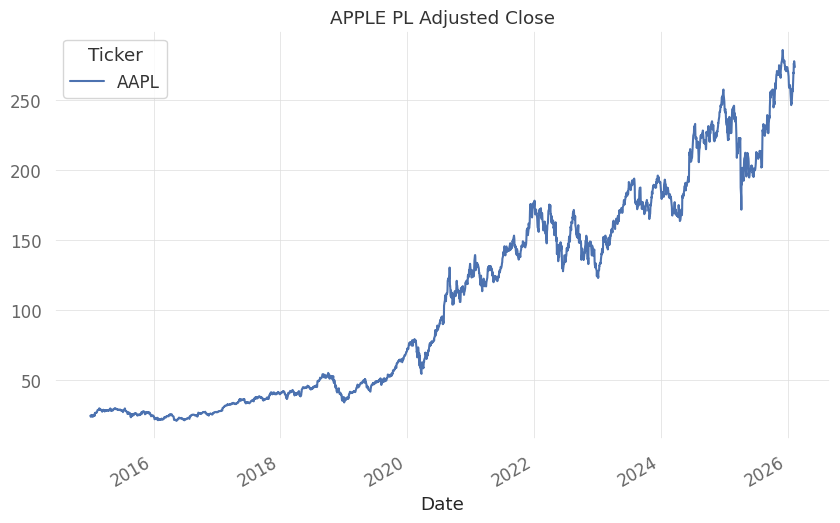

In [3]:
#Download Apple price data  
aapl = yf.download(
    "AAPL", 
    start = "2015-01-01",
    auto_adjust = True, #to adjust prices for dividends and splits
    progress = False #to print progress bar while downloading data
)

prices = aapl["Close"]
prices.plot(title="APPLE PL Adjusted Close")
plt.show()

**Step 2: Compute MACD**


In [9]:
# 1) Compute fast EMA and slow EMA respectively
ema12 = prices.ewm(span = 12, adjust = False).mean() #ewm is the exponential weithed view of the price series
ema26 = prices.ewm(span = 26, adjust = False).mean()

# 2) MACD line
macd = ema12 - ema26

#3) Signal line (9 day EMA of the MACD line)
signal = macd.ewm(span = 9, adjust = False).mean()

#4) Histogram
histogram = macd - signal

#5) Basic trading signals
bullish_cross = (macd > signal) & (macd.shift(1) <= signal.shift(1))
bearish_cross = (macd < signal) & (macd.shift(1) >= signal.shift(1))

print("Bullish signals:", bullish_cross.sum())
print("Bearish signals:", bearish_cross.sum())


Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    100
dtype: int64


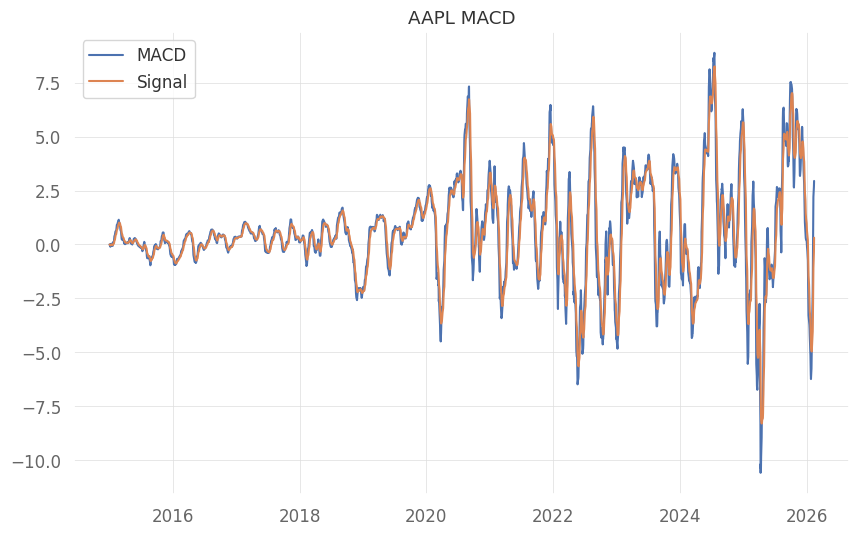

In [10]:

plt.figure()
plt.plot(macd, label="MACD")
plt.plot(signal, label="Signal")
plt.legend()
plt.title("AAPL MACD")
plt.show()


ticker: AAPL
start: 2015-01-01
end: 2026-02-10
initial_capital: 1000000.000000
ending_value_strategy: 7550735.084206
ending_value_buyhold: 11302136.744327
profit_strategy: 6550735.084206
profit_pct_strategy: 6.550735
max_drawdown_strategy: -0.270335
trades: 199
fee_rate_per_trade: 0.000500


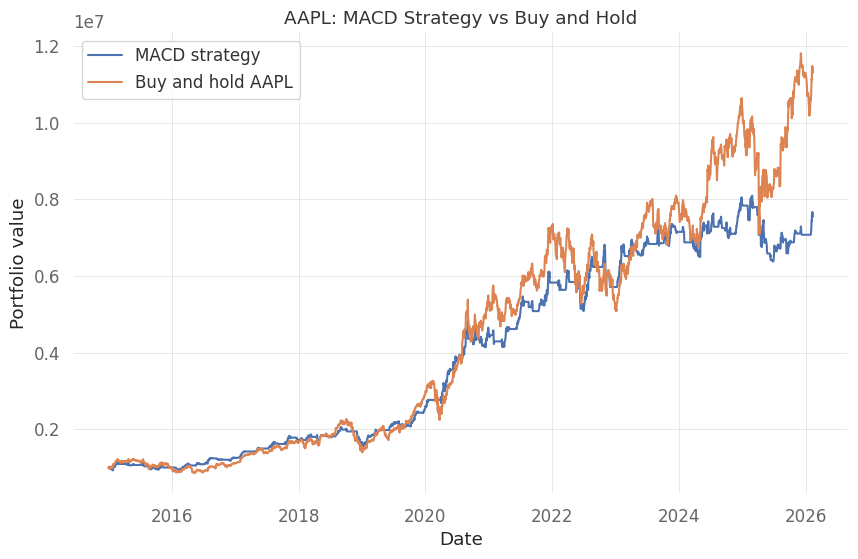

In [11]:

def backtest_macd(
    ticker: str = "AAPL",
    start: str = "2015-01-01",
    initial_capital: float = 1_000_000.0,
    fast_span: int = 12,
    slow_span: int = 26,
    signal_span: int = 9,
    fee_rate_per_trade: float = 0.0005
):
    data = yf.download(
        ticker,
        start=start,
        auto_adjust=True,
        progress=False
    )

    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    prices = close.dropna().astype(float)

    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    hist = macd - signal

    raw_position = (macd > signal).astype(int)
    position = raw_position.shift(1).fillna(0).astype(int)

    returns = prices.pct_change().fillna(0.0)
    trades = position.diff().abs().fillna(0.0)

    strategy_returns_gross = position * returns
    strategy_returns_net = strategy_returns_gross - trades * fee_rate_per_trade

    equity_strategy = initial_capital * (1.0 + strategy_returns_net).cumprod()

    # Buy-and-hold benchmark (same initial capital)
    equity_buyhold = initial_capital * (prices / prices.iloc[0])

    final_value = float(equity_strategy.iloc[-1])
    profit = final_value - initial_capital
    profit_pct = final_value / initial_capital - 1.0

    running_max = equity_strategy.cummax()
    drawdown = equity_strategy / running_max - 1.0
    max_drawdown = float(drawdown.min())

    results = {
        "ticker": ticker,
        "start": start,
        "end": str(equity_strategy.index[-1].date()),
        "initial_capital": float(initial_capital),
        "ending_value_strategy": float(equity_strategy.iloc[-1]),
        "ending_value_buyhold": float(equity_buyhold.iloc[-1]),
        "profit_strategy": float(profit),
        "profit_pct_strategy": float(profit_pct),
        "max_drawdown_strategy": float(max_drawdown),
        "trades": int(trades.sum()),
        "fee_rate_per_trade": float(fee_rate_per_trade),
    }

    return prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results


# ---- Run ----
prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results = backtest_macd(
    ticker="AAPL",
    start="2015-01-01",
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005
)

for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# ---- Plot: strategy vs buy-and-hold ----
plt.figure()
plt.plot(equity_strategy, label="MACD strategy")
plt.plot(equity_buyhold, label="Buy and hold AAPL")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()




WHYY????

Stress tests
2020 type crash, 2022 rates shock -> this MACD method do good here???

2020 crash was:

Extremely fast

~35% drop in about 1 month

Followed by extremely fast V-shaped recovery

MACD is based on EMAs:

12-day EMA

26-day EMA

9-day signal

Those are lagging indicators.

What happens mechanically?

Market crashes quickly.

MACD turns bearish AFTER damage already occurred.

You exit late.

Market reverses violently.

MACD re-enters late.

You miss part of recovery.

This is classic lag behavior.

Fast crash + fast recovery = worst environment for MACD.

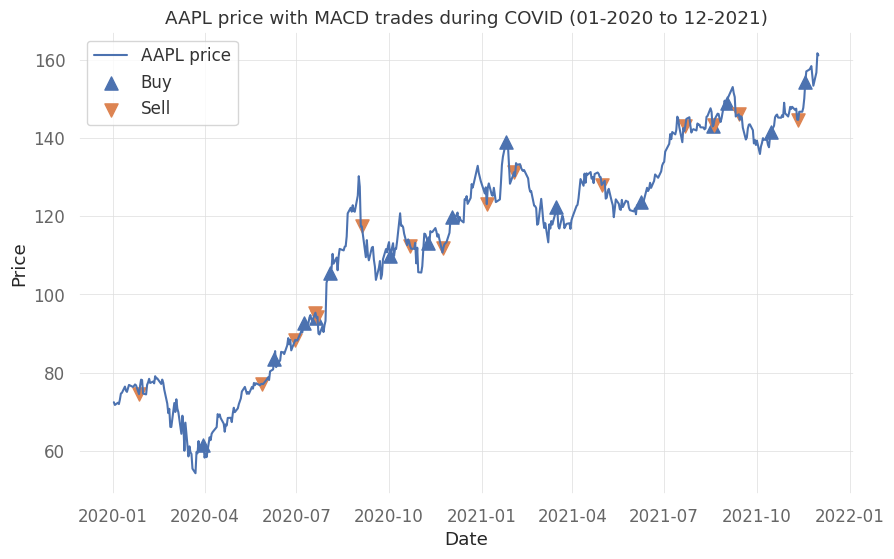

In [26]:

# ---- choose window ----
start_view = "2020-01-01"
end_view   = "2021-12-01"

# Slice
px = prices.loc[start_view:end_view]
pos = position.reindex(px.index).fillna(0).astype(int)

# Entry and exit dates
chg = pos.diff().fillna(0)
buy_dates = chg[chg == 1].index
sell_dates = chg[chg == -1].index

plt.figure()
plt.plot(px.index, px.values, label="AAPL price")

plt.scatter(buy_dates, px.loc[buy_dates], marker="^", s=90, label="Buy")
plt.scatter(sell_dates, px.loc[sell_dates], marker="v", s=90, label="Sell")

plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()




In [25]:

# Calculate returns
strategy_returns = equity_strategy.pct_change().dropna()
benchmark_returns = equity_buyhold.pct_change().dropna()

# Align dates
df = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()

# Generate HTML report
qs.reports.html(
    df.iloc[:, 0],
    benchmark=df.iloc[:, 1],
    output="report.html",
    title="Strategy vs Benchmark"
)

print("Done: performancereportMACD.html")



findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Done: performancereportMACD.html


When MACD Actually Works Best

MACD performs best in:

Long sustained bull markets

Long sustained bear markets

Smooth macro trends

Lower noise environments

It performs poorly in:

V-shaped reversals

Mean-reverting chop

Sudden shock events

2020 and 2022 are NOT classic trend-following environments.

They are volatility shock environments.

LOSSES exits but rarely exceed 3%